# 5. Regularization vs Overfitting, Ridge Regression

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (25/11/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset generation

As in Notebook 3., we will generate prices $ y_i $ as a polynomial function  of the surface $ x_i $.

In this notebook, we will assume that the function f(x), giving the price of an appartment with surface $ x $, will be defined as

$$ f(x) = 100000 + 14373x + 3x^3. $$

In addition, we will add a random noise to the final pricing, with a $ +/- 5\% $ drift as before.

In [2]:
# All helper functions
min_surf = 40
max_surf = 150
def surface(min_surf, max_surf):
    # Note, we changed the surface inputs to be normalized by the value of max_surf.
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this will return the price in millions of SGD.
    surface = surface
    return round((100000 + 14373*surface + 3*surface**3)*(1 + np.random.uniform(-0.1, 0.1)), 2)/1000000
def get_x_list(l):
    return [v[0] for v in l]
def get_y_list(l):
    return [v[1] for v in l]
def linreg(a, b, min_surf, max_surf, n_points = 50):
    return [(x, a*x + b) for x in np.linspace(min_surf, max_surf, n_points)]
def loss_mse(a, b, x, y):
    val =  sum([(y_i - (a*x_i + b))**2 for x_i, y_i in zip(x, y)])/len(x)
    return '{:.2e}'.format(val)

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
np.random.seed(27)
n_points = 25
dataset = [(s := surface(min_surf, max_surf), price(s)) for _ in range(n_points)]
inputs = get_x_list(dataset)
outputs = get_y_list(dataset)

### Train-Test Splitting

As in Notebook 4, we will use a basic train-test split, with a ratio of 80-20%.

In [4]:
# Train-test split parameters
ratio_train = 0.8
split_index = int(n_points*ratio_train)
# Training inputs and outputs
train_dataset = dataset[:split_index]
train_inputs = get_x_list(train_dataset)
train_outputs = get_y_list(train_dataset)
# Testing inputs and outputs
test_dataset = dataset[split_index:]
test_inputs = get_x_list(test_dataset)
test_outputs = get_y_list(test_dataset)

### Training an overfitting polynomial regressor.

As in Notebook 4, we will use a polynomial regressor with a degree higher than needed (6, instead of 3) and will reuse the helper functions we have introduced earlier.

In [5]:
# Training a Polynomial Regressor
n_degree = 6
sk_inputs = np.array(train_inputs).reshape(-1, 1)
sk_outputs = np.array(train_outputs)
sk_poly = PolynomialFeatures(degree = n_degree, include_bias = False)
sk_poly_inputs = sk_poly.fit_transform(sk_inputs.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(sk_poly_inputs, sk_outputs)
a_sk = poly_reg_model.coef_
b_sk = poly_reg_model.intercept_
print(a_sk, b_sk)

[ 5.18463330e+00 -1.72903122e-01  2.98769822e-03 -2.80005598e-05
  1.35374422e-07 -2.63855993e-10] -62.44840051178086


In [6]:
def polyreg(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    return [(x, poly_reg_model.predict(np.array([[x**(i+1) for i in range(n_degree)]]))) for x in np.linspace(min_surf, max_surf, n_points)]

In [7]:
def loss_mse_poly(poly_reg_model, n_degree, inputs, outputs):
    values = [(y, poly_reg_model.predict(np.array([[x**(i+1) for i in range(n_degree)]]))[0]) for x, y in zip(inputs, outputs)]
    losses = [(v[0] - v[1])**2 for v in values]
    val = sum(losses)/len(inputs)
    return '{:.2e}'.format(val)

In [8]:
loss_train = loss_mse_poly(poly_reg_model, n_degree, train_inputs, train_outputs)
print(loss_train)
loss_test = loss_mse_poly(poly_reg_model, n_degree, test_inputs, test_outputs)
print(loss_test)

9.95e-02
1.39e+00


### Training a ridge regressor

Text

In [9]:
# Training a Polynomial Regressor with Regularization, aka as a Ridge model
n_degree2 = 6
sk_inputs2 = np.array(train_inputs).reshape(-1, 1)
sk_outputs2 = np.array(train_outputs)
ridge_reg = KernelRidge(alpha = 5e-1, kernel ='polynomial', degree = n_degree2)
ridge_reg.fit(sk_inputs2, sk_outputs2)

KernelRidge(alpha=0.5, degree=6, kernel='polynomial')

### Predicting with a ridge regressor

Text

In [10]:
def theoretical_values(surface, max_surf):
    avg_val = round((100000 + 14373*surface + 3*surface**3))/1000000
    min_val = 0.9*avg_val
    max_val = 1.1*avg_val
    return [min_val, avg_val, max_val]

In [11]:
# Predicting with model
new_surface = 121
out = ridge_reg.predict([[new_surface]])[0]
print(out, theoretical_values(new_surface, max_surf))

7.3280851459130645 [6.4384344, 7.153816, 7.869197600000001]


### Visualising the impact of overfitting on a ridge regressor

Text

In [12]:
def ridgereg(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    return [(x, poly_reg_model.predict(np.array([[x]]))[0]) for x in np.linspace(min_surf, max_surf, n_points)]

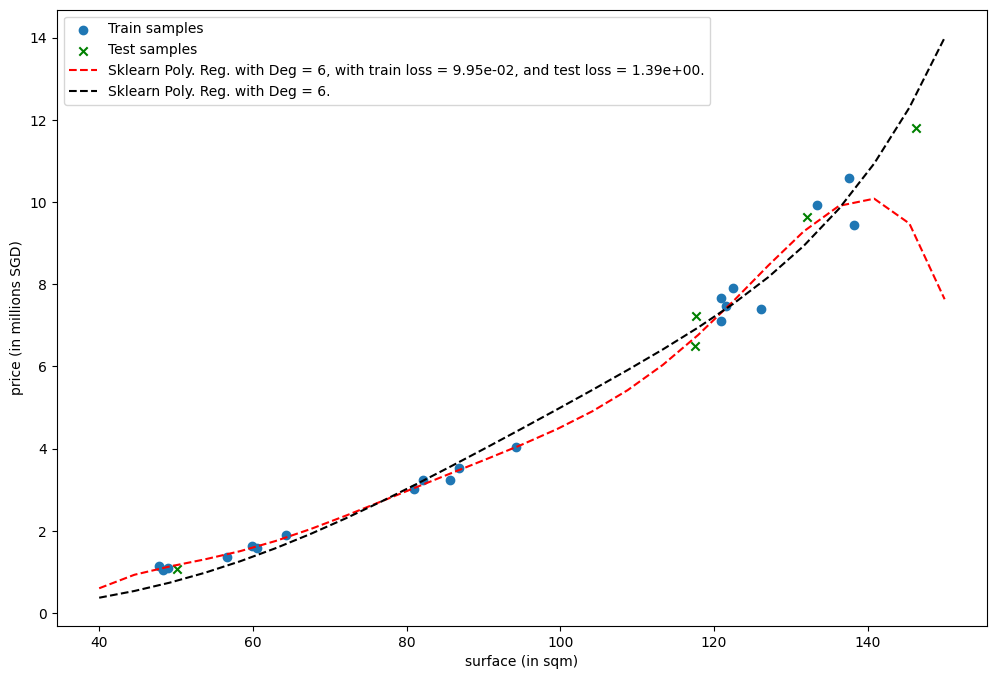

In [13]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'g', marker = "x", label = 'Test samples')
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")

# Optimal poly reg (M = 6)
polyreg_dataset = polyreg(poly_reg_model, n_degree, min_surf, max_surf, n_points)
legend = "Sklearn Poly. Reg. with Deg = 6, with train loss = {}, and test loss = {}.".format(loss_train, loss_test)
plt.plot(get_x_list(polyreg_dataset), get_y_list(polyreg_dataset), 'r--', label = legend)

# Optimal ridge reg (M = 6), but regularization helps
polyreg_dataset2 = ridgereg(ridge_reg, n_degree2, min_surf, max_surf, n_points)
legend2 = "Sklearn Poly. Reg. with Deg = 6."
plt.plot(get_x_list(polyreg_dataset2), get_y_list(polyreg_dataset2), 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

### What's next?

In the next notebook, we will discuss ...